## Bayesian multivariate normal model

# Intuition
Bayesian multivariate normal model

**FIGURE PLACEHOLDER:** ![Bayesian multivariate normal model](image_placeholder)

# Notation

## Model Assumptions

We assume that the data $D$ are independent and denote $\mathbf{Y} = (Y_1, Y_2)^T$ follow a bivariate normal distribution (consider this height and weight). 

$$
\begin{pmatrix}
Y_1 \\
Y_2
\end{pmatrix}
\mid
\theta, x
\sim \mathcal{N}\left(\begin{pmatrix}\theta_1 \\ \theta_2 \end{pmatrix}, 
\Sigma \right)
$$

Where:
- $\theta = \begin{pmatrix} \theta_1 \\ \theta_2 \end{pmatrix}$ is the unknown mean vector.
- $\Sigma$ is the covariance matrix, representing the variance within the data and the correlation between $Y_1$ and $Y_2$.


## Prior Distribution

We place a **multivariate normal** prior on $\theta$, and denote $\boldsymbol{\theta} = (\theta_1, \theta_2)^T$ 

$$
\theta \sim \mathcal{N}\left( \begin{pmatrix}\theta_0^1 \\ \theta_0^2 \end{pmatrix}, 
\Sigma_0 \right)
$$

Where $\theta_0^1$ and $\theta_0^2$ are the prior means for $Y_1$ and $Y_2$, and $\Sigma_0$ is the prior covariance matrix.


## Posterior Distribution

The posterior distribution of $\theta$ given the data is also a multivariate normal distribution, derived via Bayes' theorem:

$$
\theta \mid D \sim \mathcal{N}\left(\theta_1, \Sigma_1 \right)
$$

Where the posterior mean vector $\theta_1$ and covariance matrix $\Sigma_1$ are computed as:

- **Posterior Mean:**

$$
\theta_1 = \left( \Sigma_0^{-1} + X^T X \right)^{-1} \left( \Sigma_0^{-1} \theta_0 + X^T y \right)
$$

Where $X^T X$ is the design matrix, and $y$ represents the observed data.

- **Posterior Covariance:**

$$
\Sigma_1 = \left( \Sigma_0^{-1} + X^T X \right)^{-1}
$$


## Summary

In the multivariate version, the main difference lies in the **mean vector** and the **covariance matrix**, which describe the multivariate relationships between $Y_1$ and $Y_2$. This allows Bayesian inference to be applied in more complex scenarios where multiple dependent variables are considered together.


# Example

Here we use height and weight and study the bi-variate normal distribution.

In [91]:
rm(list=ls())
set.seed(2)

# Simulate true mean and effect size for both height and weight
baseline_height <- 170  # Population mean of height when the genetic variant has no effect
baseline_weight <- -20   # Population mean of weight when the genetic variant has no effect minus the effect of height
theta_true_height <- 2  # True effect size for height
theta_true_weight <- 0.1  # True effect size for weight (direct effect of genotype on weight)
beta_height_weight <- 0.5  # Effect of height on weight (correlation effect)

sd_height <- 1          # Standard deviation of height
sd_weight <- 1          # Standard deviation of weight

# Randomly generate genotype based on probability p
# genotype <- c(1,2,0)
# Set parameters
p <- 0.2  # Probability for genotype 1
size <- 10  # Number of trials

# Randomly generate genotype based on probability p
genotype <- sample(c(0, 1, 2), size = size, replace = TRUE, prob = c(1 - p, p * (1 - p), p^2))


# Simulate height values for three individuals based on genotypes
n = length(genotype)
height_values <- rnorm(n, mean = baseline_height + theta_true_height * genotype, sd = sd_height)

# Simulate weight values for three individuals based on genotypes and height
weight_values <- rnorm(n, mean = baseline_weight + theta_true_weight * genotype + beta_height_weight * height_values, sd = sd_weight)

# Display the simulated data
data.frame(genotype = genotype, height = height_values, weight = weight_values)

genotype,height,weight
<dbl>,<dbl>,<dbl>
0,170.1324,62.75514
0,170.7080,66.23258
0,169.7603,64.91596
0,171.9845,67.00507
1,171.8612,66.46287
1,172.4177,68.39964
0,170.9818,64.29095
1,171.6073,67.49329
0,168.9603,66.43482


In [92]:
# Create a grid of theta values for height and weight
theta_vals_height <- seq(-1, 2, length.out = 100)
theta_vals_weight <- seq(-1, 2, length.out = 100)

# Prior parameters for height and weight
theta_0_height <- 0.3  # Prior mean of height's theta
theta_0_weight <- 0.3  # Prior mean of weight's theta
sigma_0_height <- 0.4  # Prior standard deviation of height's theta
sigma_0_weight <- 0.4  # Prior standard deviation of weight's theta
tau_0_height <- 1 / sigma_0_height^2 # Prior precision of height's theta
tau_0_weight <- 1 / sigma_0_weight^2 # Prior precision of weight's theta

# Compute prior densities for height and weight
prior_density_height <- dnorm(theta_vals_height, mean = theta_0_height, sd = sigma_0_height)
prior_density_weight <- dnorm(theta_vals_weight, mean = theta_0_weight, sd = sigma_0_weight)

# Print prior information
message(" ======= Prior Information for height and weight ======= ")
cat("Prior mean of height's theta:", theta_0_height, "\n")
cat("Prior mean of weight's theta:", theta_0_weight, "\n")
cat("Prior standard deviation of height's theta (sigma_0_height):", sigma_0_height, "\n")
cat("Prior standard deviation of weight's theta (sigma_0_weight):", sigma_0_weight, "\n")


 ======= Prior Information for height and weight ======= 



Prior mean of height's theta: 0.3 
Prior mean of weight's theta: 0.3 
Prior standard deviation of height's theta (sigma_0_height): 0.4 
Prior standard deviation of weight's theta (sigma_0_weight): 0.4 


In [93]:
# Calculate the log-likelihood for each theta value for both height and weight
loglikelihood_bivariate <- function(theta_height, theta_weight, genotype, height, weight, baseline_height, baseline_weight, sd_height, sd_weight, beta_height_weight) {
  n <- length(genotype)
  log_likelihood <- sum(dnorm(height, mean = baseline_height + theta_height * genotype, sd = sd_height, log = TRUE)) + 
                    sum(dnorm(weight, mean = baseline_weight + theta_weight * genotype + beta_height_weight * height, sd = sd_weight, log = TRUE))
  return(log_likelihood)
}

# Calculate log-likelihood for each combination of height and weight
log_likelihood_vals_height <- sapply(theta_vals_height, function(theta_h) loglikelihood_bivariate(theta_h, theta_0_weight, genotype, height_values, weight_values, baseline_height, baseline_weight, sigma_0_height, sigma_0_weight, beta_height_weight))
log_likelihood_vals_weight <- sapply(theta_vals_weight, function(theta_w) loglikelihood_bivariate(theta_0_height, theta_w, genotype, height_values, weight_values, baseline_height, baseline_weight, sigma_0_height, sigma_0_weight, beta_height_weight))

In [94]:
# Compute unnormalized posterior densities
posterior_vals_height <- exp(log_likelihood_vals_height) * prior_density_height
posterior_vals_weight <- exp(log_likelihood_vals_weight) * prior_density_weight

# Calculate the posterior mean for height and weight
posterior_mean_height <- sum(theta_vals_height * posterior_vals_height) / sum(posterior_vals_height)
posterior_mean_weight <- sum(theta_vals_weight * posterior_vals_weight) / sum(posterior_vals_weight)

# Calculate the posterior variance for height and weight
posterior_variance_height <- sum((theta_vals_height - posterior_mean_height)^2 * posterior_vals_height) / sum(posterior_vals_height)
posterior_variance_weight <- sum((theta_vals_weight - posterior_mean_weight)^2 * posterior_vals_weight) / sum(posterior_vals_weight)

# Print the posterior results
message(" ======= Posterior Information for height and weight ======= ")
cat("Posterior mean of height's theta:", posterior_mean_height, "\n")
cat("Posterior mean of weight's theta:", posterior_mean_weight, "\n")
cat("Posterior standard deviation of height's theta (sigma_1_height):", sqrt(posterior_variance_height), "\n")
cat("Posterior standard deviation of weight's theta (sigma_1_weight):", sqrt(posterior_variance_weight), "\n")


 ======= Posterior Information for height and weight ======= 



Posterior mean of height's theta: 1.541389 
Posterior mean of weight's theta: 1.178168 
Posterior standard deviation of height's theta (sigma_1_height): 0.193788 
Posterior standard deviation of weight's theta (sigma_1_weight): 0.1999741 


[1] 99

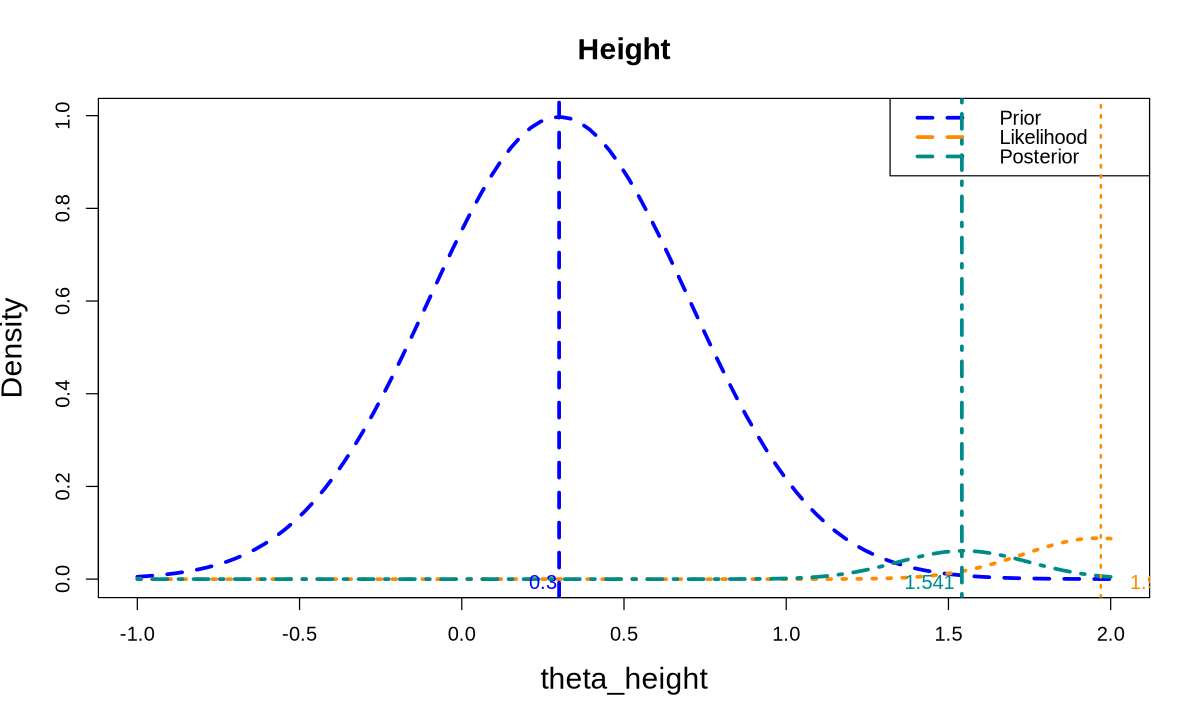

In [95]:
# Plot prior and posterior for height
plot(theta_vals_height, prior_density_height, type = "l", col = "blue", lwd = 3, 
     ylim = c(0, max(c(prior_density_height, exp(log_likelihood_vals_height), posterior_vals_height))),
     xlab ="theta_height", ylab = "Density", 
     main = "Height", cex.lab = 1.5, cex.main = 1.5, lty = 2)
lines(theta_vals_height, exp(log_likelihood_vals_height) / sum(exp(log_likelihood_vals_height)), col = "darkorange", lwd = 3, lty = 3)  # Likelihood density
lines(theta_vals_height, posterior_vals_height / sum(posterior_vals_height), col = "darkcyan", lwd = 3, lty = 4)  # Posterior density
legend("topright", legend = c("Prior", "Likelihood", "Posterior"),
       col = c("blue", "darkorange", "darkcyan"), lwd = 3, lty = 2, cex = 1)

# Add vertical lines for means
abline(v = theta_0_height, col = "blue", lty = 2, lwd = 3)  # Prior mean

# Find the likelihood mean for height (approximately at the maximum of the likelihood)
likelihood_max_index_height <- which.max(exp(log_likelihood_vals_height) / sum(exp(log_likelihood_vals_height)))
likelihood_mean_height <- theta_vals_height[likelihood_max_index_height]
likelihood_max_index_height
abline(v = likelihood_mean_height, col = "darkorange", lty = 3, lwd = 2)  # Likelihood mean

# Calculate the posterior mean for height
posterior_mean_height <- sum(theta_vals_height * (posterior_vals_height / sum(posterior_vals_height)))
abline(v = posterior_mean_height, col = "darkcyan", lty = 4, lwd = 3)  # Posterior mean

# Label x-axis with mean values for height
text(theta_0_height - 0.05, 0.03, labels = round(theta_0_height, 3), col = "blue", cex = 1, pos = 1)  # Prior mean
text(likelihood_mean_height + 0.15, 0.03, labels = round(likelihood_mean_height, 3), col = "darkorange", cex = 1, pos = 1)  # Likelihood mean
text(posterior_mean_height - 0.1, 0.03, labels = round(posterior_mean_height, 3), col = "darkcyan", cex = 1, pos = 1)  # Posterior mean


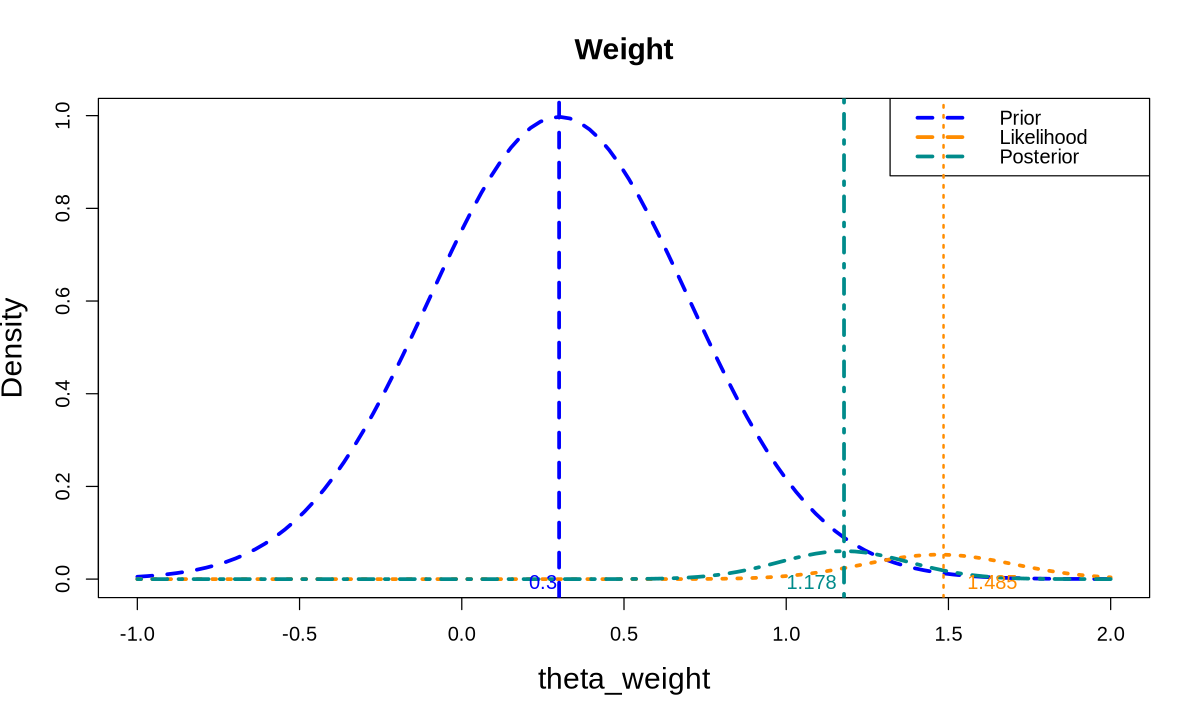

In [96]:
# Plot prior and posterior for weight
plot(theta_vals_weight, prior_density_weight, type = "l", col = "blue", lwd = 3, 
     ylim = c(0, max(c(prior_density_weight, exp(log_likelihood_vals_weight), posterior_vals_weight))),
     xlab ="theta_weight", ylab = "Density", 
     main = "Weight", cex.lab = 1.5, cex.main = 1.5, lty = 2)
lines(theta_vals_weight, exp(log_likelihood_vals_weight) / sum(exp(log_likelihood_vals_weight)), col = "darkorange", lwd = 3, lty = 3)  # Likelihood density
lines(theta_vals_weight, posterior_vals_weight / sum(posterior_vals_weight), col = "darkcyan", lwd = 3, lty = 4)  # Posterior density
legend("topright", legend = c("Prior", "Likelihood", "Posterior"),
       col = c("blue", "darkorange", "darkcyan"), lwd = 3, lty = 2, cex = 1)

# Add vertical lines for means
abline(v = theta_0_weight, col = "blue", lty = 2, lwd = 3)  # Prior mean

# Find the likelihood mean for weight (approximately at the maximum of the likelihood)
likelihood_max_index_weight <- which.max(exp(log_likelihood_vals_weight) / sum(exp(log_likelihood_vals_weight)))
likelihood_mean_weight <- theta_vals_weight[likelihood_max_index_weight]
abline(v = likelihood_mean_weight, col = "darkorange", lty = 3, lwd = 2)  # Likelihood mean

# Calculate the posterior mean for weight
posterior_mean_weight <- sum(theta_vals_weight * (posterior_vals_weight / sum(posterior_vals_weight)))
abline(v = posterior_mean_weight, col = "darkcyan", lty = 4, lwd = 3)  # Posterior mean

# Label x-axis with mean values for weight
text(theta_0_weight - 0.05, 0.03, labels = round(theta_0_weight, 3), col = "blue", cex = 1, pos = 1)  # Prior mean
text(likelihood_mean_weight + 0.15, 0.03, labels = round(likelihood_mean_weight, 3), col = "darkorange", cex = 1, pos = 1)  # Likelihood mean
text(posterior_mean_weight - 0.1, 0.03, labels = round(posterior_mean_weight, 3), col = "darkcyan", cex = 1, pos = 1)  # Posterior mean


# Supplementary

## Bayesian Inference

We assume the normal priors for the effect sizes $\beta_1$ and $\beta_2$:
$$
\beta_1, \beta_2 \sim \mathcal{N}(\beta_0, 1/\tau_0),
$$
where $\beta_1$ and $\beta_2$ are the effect sizes for the two genetic variants, and $\beta_0$ is the prior mean, while $\tau_0$ is the prior precision.

Using Bayesian updating, the posterior distribution of $\beta_1$ and $\beta_2$ is given by:
$$
\begin{pmatrix}
\beta_1 \\
\beta_2
\end{pmatrix}
| X \sim \mathcal{N} \left( \begin{pmatrix} \beta_1^* \\ \beta_2^* \end{pmatrix}, \Sigma^* \right),
$$
where:
- The posterior precision matrix $\Sigma^*$ is the inverse of the sum of the prior precision matrix and the data precision matrix:
  $$
  \Sigma^* = \left( \tau_0 I + X^T X / \sigma^2 \right)^{-1},
  $$
  with $X$ being the matrix of genotype values, and $\sigma^2$ being the variance of the trait.
  
- The posterior mean vector $\begin{pmatrix} \beta_1^* \\ \beta_2^* \end{pmatrix}$ is given by:
  $$
  \begin{pmatrix} \beta_1^* \\ \beta_2^* \end{pmatrix}
  = \Sigma^* \left( \frac{1}{\sigma^2} X^T y + \tau_0 \beta_0 \right),
  $$
  where $y$ is the vector of observed trait values, and $X$ is the matrix of genotype values (with each column corresponding to the genotype of each individual for the two variants).

This framework allows us to update our belief about the effect sizes $\beta_1$ and $\beta_2$ after observing the trait data, incorporating both prior knowledge and observed data.


In [2]:
# Create a grid of beta values for beta_1 and beta_2
beta_vals_1 <- seq(-2, 2, length.out = 100)  # Grid for beta_1
beta_vals_2 <- seq(-2, 2, length.out = 100)  # Grid for beta_2
beta_grid <- expand.grid(beta_1 = beta_vals_1, beta_2 = beta_vals_2)

### Prior distribution

In [3]:
# Prior parameters for the multivariate model
mu_0 <- c(0, 0)  # Prior mean vector for beta_1 and beta_2
sigma_0 <- 0.5    # Prior standard deviation for both beta_1 and beta_2
tau_0 <- 1 / sigma_0^2  # Prior precision for both beta_1 and beta_2
Sigma_0 <- sigma_0^2 * diag(2)  # Prior covariance matrix (diagonal for independence)

# Compute prior densities for the multivariate normal
prior_density <- dmvnorm(beta_grid, mean = mu_0, sigma = Sigma_0)

# Print prior information
cat("Prior Information for beta_1 and beta_2:\n")
cat("Mean of mu_0:", mu_0, "\n")
cat("Standard Deviation (sigma_0):", sigma_0, "\n")
cat("Precision (tau_0 = 1/sigma_0^2):", tau_0, "\n")
cat("Covariance Matrix (Sigma_0):\n")
print(Sigma_0)


Prior Information for beta_1 and beta_2:
Mean of mu_0: 0 0 
Standard Deviation (sigma_0): 0.5 
Precision (tau_0 = 1/sigma_0^2): 4 
Covariance Matrix (Sigma_0):
     [,1] [,2]
[1,] 0.25 0.00
[2,] 0.00 0.25


### Likelihood

In [4]:
# Matrix of genotypes for two genetic variants
X <- cbind(genotypes_1, genotypes_2)

# Function to compute the likelihood for a given set of beta_1 and beta_2
likelihood_function <- function(beta_1, beta_2) {
  # Predicted trait values based on the current beta values
  predicted_trait_values <- X %*% c(beta_1, beta_2)  # Linear model: X*beta
  
  # Compute the likelihood (normal density for each data point)
  likelihood_values <- dnorm(trait_values, mean = predicted_trait_values, sd = sigma)
  
  # Return the product of likelihoods for all observations (log-likelihood is usually computed for stability)
  return(prod(likelihood_values))
}

# Apply the likelihood function to the grid of beta values
likelihood_values <- apply(beta_grid, 1, function(row) likelihood_function(row[1], row[2]))

### Posterior distribution

In [5]:
# Compute the unnormalized posterior by multiplying likelihood and prior
posterior_values <- likelihood_values * prior_density

# Normalize the posterior to get a proper probability distribution
posterior_values_normalized <- posterior_values / sum(posterior_values)

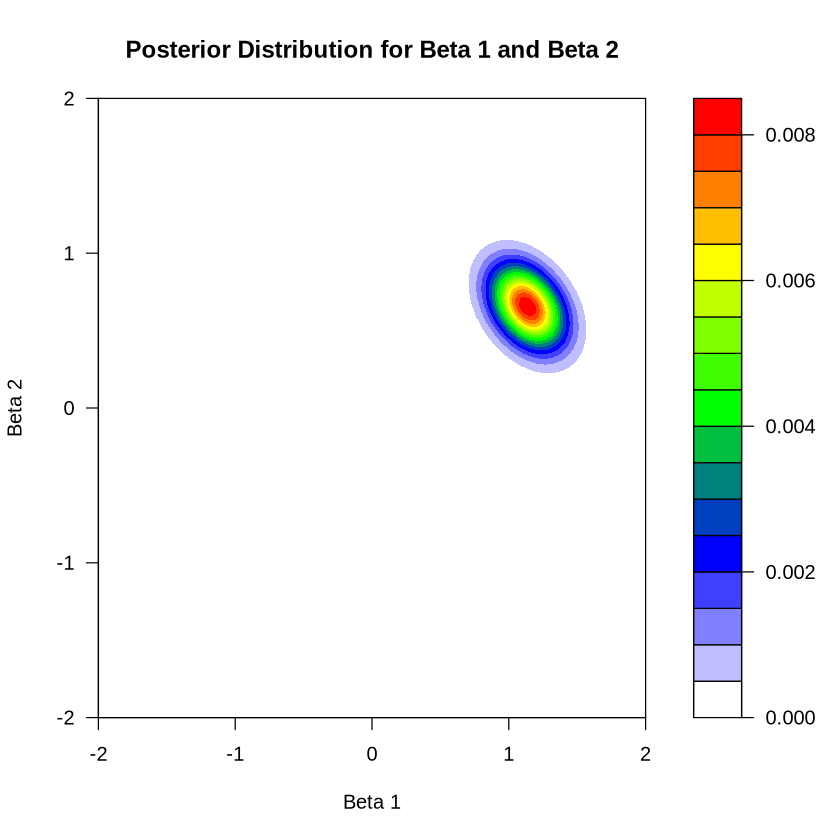

In [6]:
posterior_matrix <- matrix(posterior_values_normalized, nrow = length(beta_vals_1), byrow = TRUE)

# Plot posterior as a heatmap
filled.contour(beta_vals_1, beta_vals_2, posterior_matrix, 
               xlab = "Beta 1", ylab = "Beta 2", 
               main = "Posterior Distribution for Beta 1 and Beta 2",
               color.palette = colorRampPalette(c("white", "blue", "green", "yellow", "red")))
